In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import odeint
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet

In [42]:
import matplotlib.colors as mcolors

c0 = 'tab:orange' #predicted
c1 = 'tab:green'  #simulated

# Parameters set

In [43]:
# parameters

t_max = 180             # シミュレーション日数
dt    = 0.001
pop   = 1000000         # シミュレーション人口（100万人）
b     = 1               # ルーズなb
m     = 0.04            # E→S
g     = 0.2 - m         # E -> I 1/incubtation
dh    = 0.007           # mortality in confirmed case（7%）/infectious period（10日）
rh    = 0.093           # d_i + r_i = Constant(1/infectious period（10日）) 
do    = 0.010           # mortality in unconfirmed case（4%）/infectious period（10日）
ro    = 0.090           # d_o + r_o = Constant(1/infectious period（10日）)

#初期状態

Sh = 1
Eh = 1
Ih = 1
Rh = 0
Dh = 0

So = 999900
Eo = 0
Io = 97
Ro = 0
Do = 0

ini_state = [Sh, Eh, Ih, Rh, Dh, So, Eo, Io, Ro, Do
    ]

# Defining functions

In [44]:
def sigmoid(a):
    e = math.e
    s = 1 / (1 + e**-a)
    return s

In [45]:
def tSEIRD(v, t, a, m, b, g, rh, dh, ro, do, n, p, Se, Sp, cap):
    beds = np.sum(ini_state) * cap
    return [
        - b * v[0] * v[2]/ (v[0] + v[1] + v[2]) + m * v[1] - a * v[0], #[0] S_h
        b * v[0] * v[2] / (v[0] + v[1] + v[2]) - (m + g) * v[1] + n * (1 - Sp) * v[6] * sigmoid(beds-(v[0]+v[1]+v[2])), #[1] E_h
        g * v[1] - (rh + dh) * v[2] + p * Se * v[7] * sigmoid(beds-(v[0]+v[1]+v[2])), #[2] I_h
        rh * v[2], #[3] R_h
        dh * v[2], #[4] D_h
        - b * v[5] * v[7] / (v[5] + v[6] + v[7] + v[8] + v[3]) + m * v[6] + a * v[0], #[5] S_o
        b * v[5] * v[7] / (v[5] + v[6] + v[7] + v[8] + v[3]) - (m + g) * v[6] - n * (1 - Sp) * v[6] * sigmoid(beds - (v[0]+v[1]+v[2])) ,#[6] E_o
        g * v[6] - (ro + do) * v[7] - p * Se * v[7] * sigmoid(beds - (v[0]+v[1]+v[2])), #[7] I_o
        ro * v[7], #[8] R_o
        do * v[7] #[9] D_o
                ]

In [46]:
def tSEIRD_matrix(n,p,Se=0.7,Sp=0.7,cap=0.1,a=0):

    times = np.arange(0, t_max, dt)
    args = (a, m, b, g, rh, dh, ro, do, n, p, Se, Sp, cap)

    result = odeint(tSEIRD, ini_state, times, args)

    df = pd.DataFrame(result)
    
    df['Sh'] = df[0]# / 1000
    df['Eh'] = df[1]# / 1000
    df['Ih'] = df[2]# / 1000
    df['Rh'] = df[3]# / 1000
    df['Dh'] = df[4]# / 1000
    
    df['So'] = df[5]# / 1000
    df['Eo'] = df[6]# / 1000
    df['Io'] = df[7]# / 1000
    df['Ro'] = df[8]# / 1000
    df['Do'] = df[9]# / 1000
    
    df['Susceptible'] = (df[0] + df[5])# / 1000 #10
    df['Exposed']     = (df[1] + df[6])# / 1000 #11
    df['Infectious']  = (df[2] + df[7])# / 1000 #12
    df['Recovered']   = (df[3] + df[8])# / 1000 #13
    df['Dead']        = (df[4] + df[9])# / 1000 #14

    df['Hospitalised']= (df[0] + df[1] + df[2])# / 1000 #15
    df['Outside']     = (df[3] + df[5] + df[6] + df[7] + df[8])# / 1000 #16
    
    df['TP']          = (p * Se * df[7])# / 1000 #17
    df['FP']          = (n * (1 - Sp) * df[6])# / 1000 #18
    df['Positive']    = df['TP'] + df['FP'] #19

    df['all']         = (df[0]+df[1]+df[2]+df[3]+df[4]+df[5]+df[6]+df[7]+df[8]+df[9])# / 1000 #20
    df['beta_in']     = b / df['Hospitalised'] #21
    df['beta_out']    = b / df['Outside'] #22
    
    df['delta_Dh']    = dh * df[2]
    df['delta_Do']    = do * df[7]

    df_ = df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], axis=1)
    
    return df_[['Infectious','TP','FP']]

In [47]:
def matrix_to_regression(n,p):
    df = tSEIRD_matrix(n,p,0.7,0.7)[1:]
    title = float(n),float(p)
    
    X = df.drop('Infectious',axis=1)
    X['product'] = X['TP'] * X['FP']
    Y = df['Infectious']

    vif = pd.DataFrame()
    vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['features'] = X.columns
    print(vif)
    
    lr = LinearRegression(fit_intercept=False)
    lr.fit(X, Y)
    
    fig, ax = plt.subplots()
    t = np.arange(1, 180)
    
    y0 = df['Infectious'][1000:1800000:1000]
    l0 = 'raw'
    ax.plot(t, y0, color=c1, label=l0)
    
    y1 = lr.predict(X)[1000:1800000:1000]
    l1 = 'lr'
    ax.plot(t, y1, color=c0, label=l1)

    ax.set_xlabel('Elasped time (days)')
    ax.set_ylabel('Infectious populations (person)')

    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')
    
    plt.ylim(0,350000)

    plt.show()

    df_coef = pd.DataFrame()
    df_coef = pd.concat([df_coef,pd.DataFrame(lr.coef_).T])
    df_coef.columns = ['TP','FP','product']
    df_coef.index = ['lr']
    print(df_coef)

# Execeute function to get overlapping line plot

<ipython-input-44-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)


   VIF Factor features
0    3.964459       TP
1    9.768303       FP
2   11.871206  product


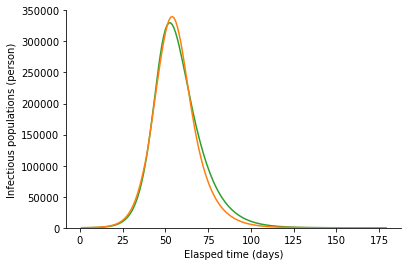

            TP        FP   product
lr  202.247081  1.274691 -0.001623


In [48]:
matrix_to_regression(0.5,0.01)

<ipython-input-44-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)


   VIF Factor features
0    4.170847       TP
1    9.719213       FP
2   11.893310  product


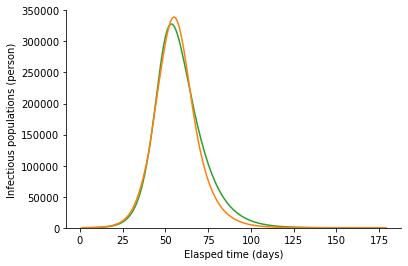

            TP        FP   product
lr  103.769117  1.382424 -0.000924


In [49]:
matrix_to_regression(0.5,0.02)

<ipython-input-44-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)


   VIF Factor features
0    4.122067       TP
1    9.796848       FP
2   12.040470  product


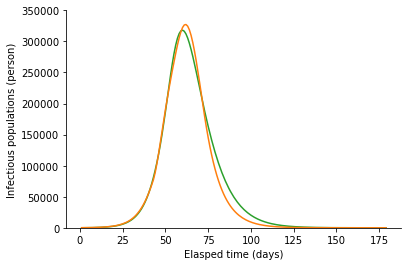

            TP        FP   product
lr  104.779927  1.409033 -0.000785


In [50]:
matrix_to_regression(0.8,0.02)

# preparation for scatter plot

In [51]:
data = pd.read_csv('coef_all.csv')

data['npr'] = data['n'] / data['p']
data['pnr'] = data['p'] / data['n']

df1 = data[data['adj_R2']>=0]
df1 = data[data['n']!=0]
df1 = data[data['p']!=0]
df1 = data[data['TP']!=0]
df1 = data[data['FP']!=0]
df1 = data.drop(['product'],axis=1)
df1

,n,p,TP,FP,adj_R2,npr,pnr
0,0.0,0.00,0.00,0.00,-0.31,NaN,NaN
1,0.0,0.01,150.69,0.00,1.00,0.000000,inf
2,0.0,0.02,79.22,0.00,1.00,0.000000,inf
3,0.0,0.03,55.38,0.00,0.99,0.000000,inf
4,0.0,0.04,43.45,0.00,0.99,0.000000,inf
...,...,...,...,...,...,...,...
10196,1.0,0.96,3.57,11.68,0.49,1.041667,0.96
10197,1.0,0.97,3.50,11.61,0.49,1.030928,0.97
10198,1.0,0.98,3.44,11.55,0.49,1.020408,0.98
10199,1.0,0.99,3.37,11.49,0.48,1.010101,0.99


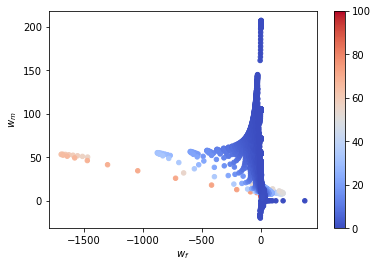

In [52]:
x1 = df1['FP']
y1 = df1['TP']

plt.scatter(x1, y1, s=20, c=df1['pnr'], cmap='coolwarm')#, s=100, c='pink', alpha=0.2, linewidths='1',edgecolors='red',label='Elastic_net')

plt.xlabel('$w_f$')
plt.ylabel('$w_m$')

# カラーバーを表示
plt.colorbar()

#plt.legend()

#plt.title('estimated weights for Pf and Pm')

## to get 'coef_all.csv', run following codes 